In [1]:
import numpy as np
from scipy.optimize import minimize
from statsmodels.tools.numdiff import approx_fprime, approx_hess
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
def transform(params, restrictions):
    params_trans = np.zeros(params.shape)
    for i in range(len(params)):
        if restrictions[i] == 'pos':
            params_trans[i] = np.log(params[i])
        elif restrictions[i] == '01':
            params_trans[i] = np.log(params[i]) - np.log(1 - params[i])
        else:
            params_trans[i] = params[i]
    return params_trans

def transform_back(params_trans, restrictions):
    params = np.zeros(params_trans.shape)
    for i in range(len(params_trans)):
        if restrictions[i] == 'pos':
            params[i] = np.exp(params_trans[i])
        elif restrictions[i] == '01':
            params[i] = 1 / (1 + np.exp(-params_trans[i]))
        else:
            params[i] = params_trans[i]
    return params

def gradient(param_trans, restrictions):
    g = np.zeros_like(param_trans)
    for i in range(len(g)):
        if restrictions[i] == '':
            g[i] = 1
        elif restrictions[i] == 'pos':
            g[i] = np.exp(param_trans[i])
        else:
            g[i] = np.exp(param_trans[i]) / np.power(1 + np.exp(param_trans[i]), 2)
    return g

In [3]:
def garch_filter(params, returns):
    un_var = params[1]/(1 - params[2] - params[3])
    sigma2 = np.zeros_like(returns)
    
    for i in range(len(returns)):
        if i == 0:
            sigma2[i] = un_var
        else:
            sigma2[i] = np.dot(un_var, (1 - params[2] - params[3])) + np.dot(params[2], (returns[i-1] - params[0]) ** 2) + np.dot(params[3], sigma2[i - 1])
    return sigma2

def normal_loglikelihood(params, returns):
    sigma2 = garch_filter(params, returns)
    lls = 0.5 * (np.log(2*np.pi) + np.log(sigma2) + (returns - params[0])**2 / sigma2)
    return sum(lls)/len(returns)

def normal_loglikelihood_trans(params_trans, returns, restrictions):
    params = transform_back(params_trans, restrictions)
    return normal_loglikelihood(params, returns)

In [4]:
np.random.seed(14)
returns = np.random.normal(0, 1, 1000)

In [5]:
init_params = np.array([0.05, 0.1, 0.02, 0.95])
restrictions = np.array(['', '01', '01', '01'])
init_params_trans = transform(init_params, restrictions)

In [6]:
opt = minimize(normal_loglikelihood_trans, 
               init_params_trans,
               args = (np.asarray(returns), restrictions),
               method = "l-bfgs-b",
               options = {'disp': None, 'maxiter': 250}
              )

In [7]:
params = transform_back(opt.x, restrictions)

grad = gradient(opt.x, restrictions)
variance = opt.hess_inv.todense() / len(returns)
high = params + 1.96 * np.multiply(np.sqrt(np.diagonal(variance)), grad)
low = params - 1.96 * np.multiply(np.sqrt(np.diagonal(variance)), grad)

table2 = pd.DataFrame(data = {'Parameters': params, 'Standard Error': np.multiply(np.sqrt(np.diagonal(variance)), grad), '95% CI lower': low, '95% CI upper': high, 't value': params/np.multiply(np.sqrt(np.diagonal(variance)), grad), 'p-value': stats.norm.sf(np.abs(params/np.multiply(np.sqrt(np.diagonal(variance)), grad))) * 2})
print('Log-likelihood: ', -opt.fun*len(returns), '\n')
display(table2)

Log-likelihood:  -1442.7246919465292 



,Parameters,Standard Error,95% CI lower,95% CI upper,t value,p-value
0,-0.087801,0.032083,-0.150683,-0.024919,-2.736702,6.205857e-03
1,0.144363,0.153138,-0.155788,0.444514,0.942698,3.458355e-01
2,0.003476,0.009427,-0.015000,0.021953,0.368772,7.122975e-01
3,0.858871,0.135255,0.593771,1.123972,6.349992,2.153258e-10


In [8]:
from arch import arch_model

am = arch_model(returns)
res  = am.fit(update_freq = 5)
print(res)

Iteration:      5,   Func. Count:     36,   Neg. LLF: 1460.90711335737
Iteration:     10,   Func. Count:     66,   Neg. LLF: 1444.6811804621777
Iteration:     15,   Func. Count:     98,   Neg. LLF: 1442.6462889827285
Iteration:     20,   Func. Count:    124,   Neg. LLF: 1442.6251561669797
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1442.6251319982616
            Iterations: 23
            Function evaluations: 138
            Gradient evaluations: 23
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -1442.63
Distribution:                  Normal   AIC:                           2893.25
Method:            Maximum Likelihood   BIC:                           2912.88
                         

In [9]:
def generate_garch(param, num_obs, display = False):
    y = np.zeros(num_obs)
    state = np.zeros(num_obs)
    for i in range(num_obs):
        if i == 0:
            state[i] = np.divide(np.take(param, 0, -1), (1 - np.take(param, 1, -1) - np.take(param, 2, -1)))
        else:
            state[i] = np.take(param, 0, -1) + np.take(param, 1, -1) * y[i-1] ** 2.0 + np.take(param, 2, -1) * state[i - 1]
        if display == True:
            print('State at {} is {}'.format(i, state[i]))
        y[i] = stats.norm.rvs(scale = np.sqrt(state[i]))
        
    return state, y

In [10]:
np.random.seed(2021)
num = 500
sigma2, returns = generate_garch([0.2, 0.2, 0.6], num)

Text(0.5, 1.0, 'Return')

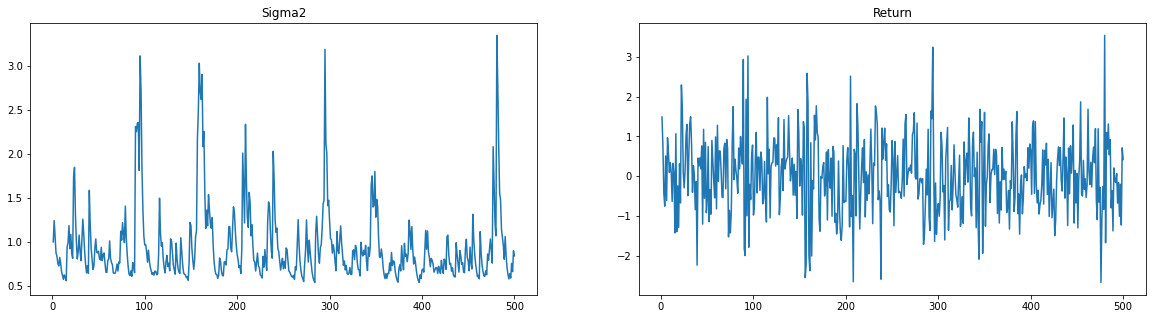

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 5, forward=True)
ax1.plot(np.linspace(1, num, num), sigma2)
ax1.set_title('Sigma2')
ax2.plot(np.linspace(1, num, num), returns)
ax2.set_title('Return')

In [13]:
init_params = np.array([0.05, 0.1, 0.02, 0.95])
restrictions = np.array(['', '01', '01', '01'])
init_params_trans = transform(init_params, restrictions)

In [14]:
opt = minimize(normal_loglikelihood_trans, 
               init_params_trans,
               args = (np.asarray(returns), restrictions),
               method = "l-bfgs-b",
               options = {'disp': None, 'maxiter': 250}
              )

In [15]:
params = transform_back(opt.x, restrictions)

grad = gradient(opt.x, restrictions)
variance = opt.hess_inv.todense() / len(returns)
high = params + 1.96 * np.multiply(np.sqrt(np.diagonal(variance)), grad)
low = params - 1.96 * np.multiply(np.sqrt(np.diagonal(variance)), grad)

table2 = pd.DataFrame(data = {'Parameters': params, 'Standard Error': np.multiply(np.sqrt(np.diagonal(variance)), grad), '95% CI lower': low, '95% CI upper': high, 't value': params/np.multiply(np.sqrt(np.diagonal(variance)), grad), 'p-value': stats.norm.sf(np.abs(params/np.multiply(np.sqrt(np.diagonal(variance)), grad))) * 2})
print('Log-likelihood: ', -opt.fun*len(returns), '\n')
display(table2)

Log-likelihood:  -669.2835649634902 



,Parameters,Standard Error,95% CI lower,95% CI upper,t value,p-value
0,0.035739,0.041399,-0.045403,0.116881,0.863278,3.879845e-01
1,0.207991,0.088404,0.034718,0.381264,2.352716,1.863686e-02
2,0.154179,0.069552,0.017858,0.290501,2.216761,2.663944e-02
3,0.612373,0.098358,0.419590,0.805155,6.225932,4.787022e-10
